# Tutorial: Architektura Mixture of Experts (MoE) w modelach językowych


Architektura Mixture of Experts (MoE) to technika stosowana w celu skalowania modeli językowych, która bazuje na architekturze Transformera. Kluczową ideą MoE jest obliczenie warunkowe (ang. conditional computation), co oznacza, że do przetworzenia każdego tokenu wejściowego aktywowany jest tylko podzbiór wszystkich parametrów modelu. Pozwala to na drastyczne zwiększenie całkowitej liczby parametrów w modelu (a tym samym jego "wiedzy") bez proporcjonalnego wzrostu kosztów obliczeniowych podczas trenowania i inferencji.

W praktyce modyfikacja polega na zastąpieniu warstw feed-forward, które występują po blokach atencji w Transformerze, tak zwaną **warstwą MoE**.

Warstwa MoE składa się z dwóch głównych elementów:
- Wielu ekspertów
- Rutera (nazywanego również bramką)

![moe-architecture](assets/moe-architecture.png)

## Ekspert

Każdy "ekspert" to w rzeczywistości standardowa sieć feed-forward. Zamiast jednej dużej sieci FFN, warstwa MoE posiada ich wiele, a każda z nich ma mniejszą liczbę parametrów. Dla każdego tokenu wejściowego aktywowany jest niewielki podzbiór tych ekspertów, a ich wyniki są następnie agregowane, najczęściej poprzez sumę ważoną, której wagi pochodzą z rutera.

#### Czego uczą się eksperci?
Nazwa ekspert może sugerować, że specjalizują się oni w różnych dziedzinach, jak matematyka, pisanie czy programowanie. Jednak zaobserwowana specjalizacja ekspertów jest znacznie bardziej "niskopoziomowa".

![ekspert-distribution.png](assets/ekspert-distribution.png)
[Rozkład tokenów przekazanych do różnych ekspertów w zależności od dziedziny, z której pochodziły dane. Źródło: https://arxiv.org/pdf/2401.04088]

<br/><br/>

![ekspert-table.png](assets/ekspert-table.png)
[Tokeny, w których specjalizowali się eksperci w różnych warstwach. Źródło: https://arxiv.org/pdf/2202.08906]


<br/><br/>

![sentence=ekspert-distribution.png](assets/sentence-ekspert-distribution.png)
[Każdy token otrzymał kolor odpowiadajacy ekspertowi będącemu pierwszym wyborem. Źródło: https://arxiv.org/pdf/2401.04088]

## Ruter

Aby zdecydować, których ekspertów użyć dla danego tokenu, wykorzystujemy ruter. Jest to sieć, która uczy się kierować każdy token do najbardziej odpowiednich ekspertów. Ruter oblicza wagi dla wszystkich ekspertów, a następnie wybiera "top-k" (np. 2 najlepszych) z nich. Wyniki wybranych ekspertów są następnie sumowane i ważone ich wagami z rutera. Ruter jest na ogół implementowany jako sieć feed forward.

Jeśli zbiór wszystkich ekspertów zdefiniujemy jako $E = \{E_1, E_2, ..., E_n\}$, a ruter jako $G(x)$, to wynik warstwy MoE dla tokenu $x$ możemy zapisać w następujący sposób:
$$y = \sum_{i=1}^{n} G(x)_i E_i(x)$$
Gdzie $G(x)_i$ to waga przypisana przez ruter i-temu ekspertowi. W praktyce większość tych wag jest zerowa, ponieważ ruter wybiera tylko kilku najlepszych ekspertów.


## Load Balancing

Zależy nam na tym, aby wszyscy eksperci byli regularnie używani - pozwala to zapewnić nam, że wszyscy eksperci będą wytrenowani oraz na lepsze zużycie mocy obliczeniowej przy rozłożeniu modelu na wiele GPU.

Niektóry sposoby na rozwiązanie tego problemu to:

#### Noisy Top-k routing [[1](https://arxiv.org/pdf/2101.03961)]
Metoda ta polega na bezpośredniej modyfikacji wyników zwracanych przez sieć rutera poprzez dodanie do nich szumu Gausa przed wyborem top-k:
$$H(x) = x * W_g + N(0,σ_2)$$
gdzie:
- $H(x)$ - wagi przypisane ekspertom przed zastosowaniem top-k
- $W_g$ - wagi rutera
- $x$ - wejście do rutera

Powyższe rozwiązanie możemy rozszerzyć poprzez danie modelowi kontroli nad ilosćią dodanego szumu [[2](https://arxiv.org/pdf/1701.06538)]:
$$H(x) = x * W_g + N(0,σ_2) * SoftPlus( x * W_{noise} )$$
gdzie:
- $H(x)$ - wagi przypisane ekspertom przed zastosowaniem top-k
- $W_g$ - wagi rutera
- $x$ - wejście do rutera
- $W_{noise}$ - macierz wag której uczymy się podczas treningu
- $SoftPlus(x) = ln(1 + e^x)$

#### Load balancing objective [[1](https://arxiv.org/pdf/2101.03961)]
W celu uzyskania zrównoważonego rozkładu wszystkich ekspertów możemy dodać wyrażenie karające ruter za faworyzację ekspertów:
$$L_{balance} = \alpha \sum_{i=1}^n f_i * P_i$$
gdzie:
- $\alpha$ - hiperparametr
- $f_i$ - procent tokenów przekierowanych do eksperta $i$
- $P_i$ - średnie prawdopodobieństwo wyboru eksperta $i$


### Przykładowe Modele MoE

| Model | Całkowita Liczba Parametrów | Aktywne Parametry (na token) | Liczba Ekspertów (Aktywni / Całkowita) |
| :--- | :--- | :--- |:---------------------------------------|
| **Mixtral 8x7B** | 47 miliardów | 13 miliardów | 2 z 8                                  |
| **Mixtral 8x22B** | 141 miliardów | 39 miliardów | 2 z 8                                  |
| **DeepSeek R1** | 671 miliardów | 37 miliardów | 1 + 8 z 256                            |


## Architektura MoE w transformerach wizyjnych

Podobnie jak kw przypadku modeli moe do modelowania języka, zastępujemy warstwę feed-forward warstwą moe.

![vit-moe.png](assets/vit-moe.png)

Pozwala nam to na uzyskanie tych samych polepszeń jak w przypadku modelowania języka. Dodatkowym trikiem używanym w wizyjnych modelach MoE jest przypisywanie znaczenia każdemu fragmentowi (patch) obrazu i procesowaniu tylko najważniejszych fragmentów.

![vit-moe-priority-scorer.png](assets/vit-moe-priority-scorer.png)
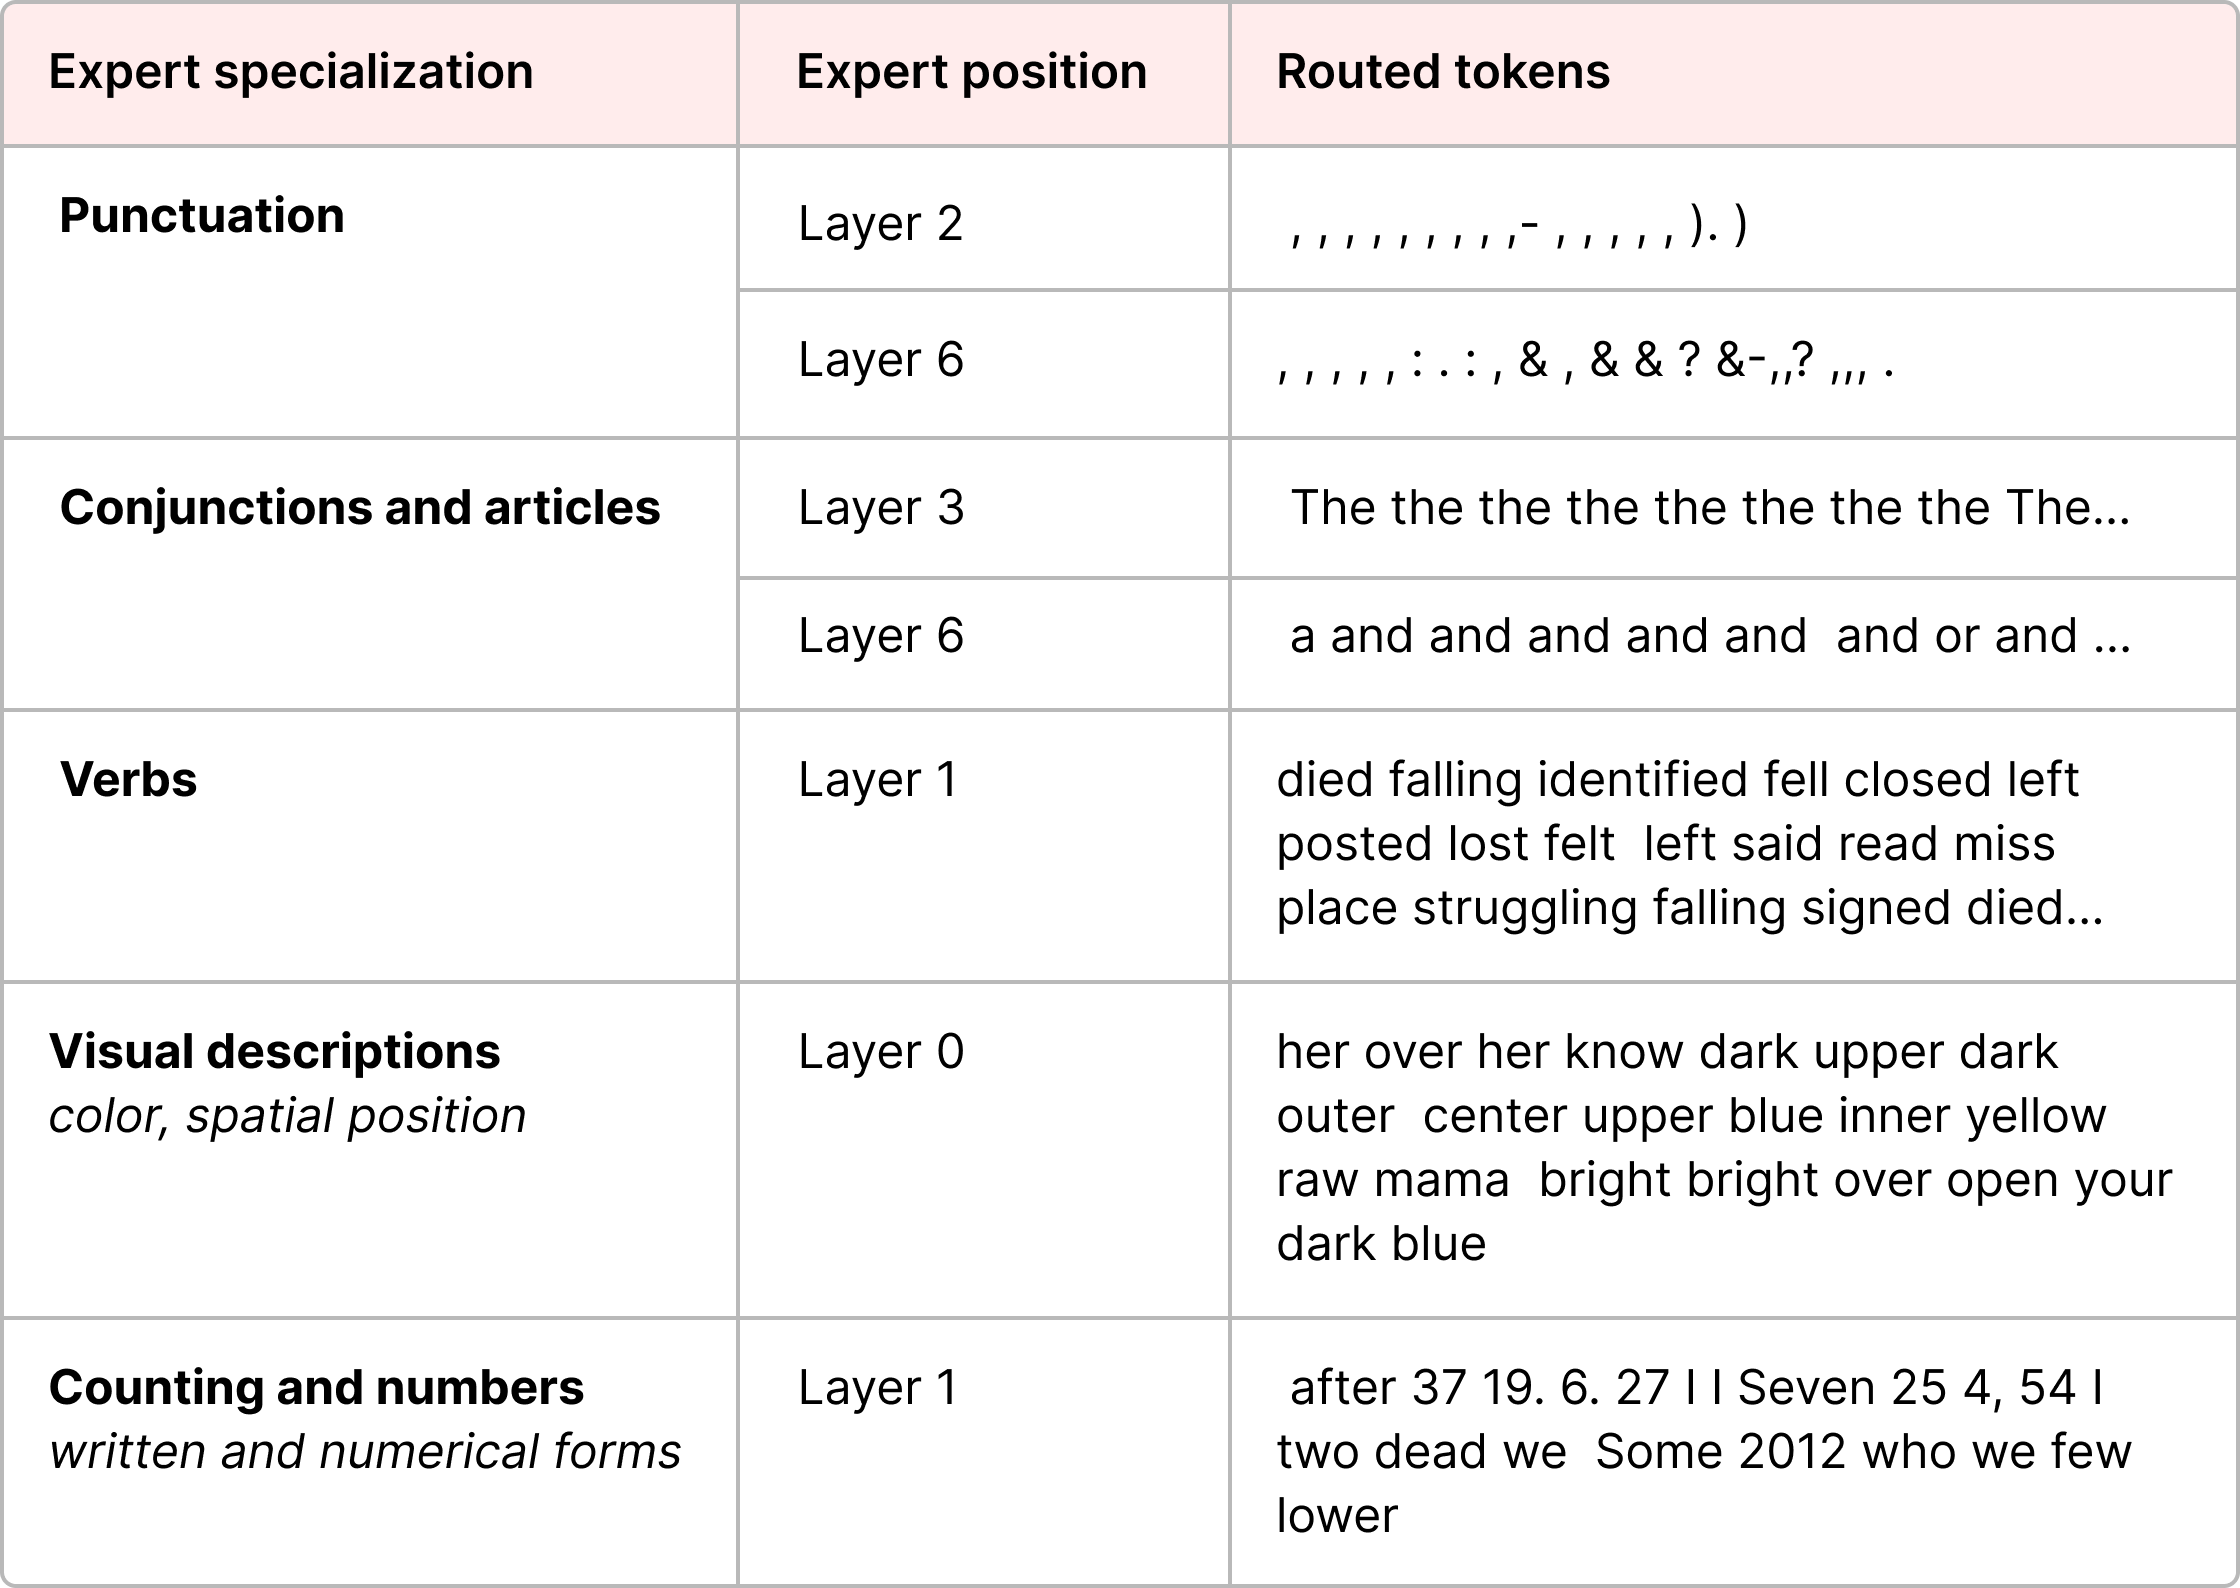